In [1]:
import os
import sys
sys.path.insert(0, '..')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
from decouple import config
import json
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

from authenticate_service_account import main
from utils import *

from sklearn.model_selection import train_test_split

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

import category_encoders as ce
from scipy import stats

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor

from keras.models import load_model

from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers, Sequential

from joblib import dump, load


In [2]:
def ants_preprocess(data):
    data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])

    data_with_layover = calculate_total_layover_time(data_with_od, as_ratio=True)

    data_with_layover2 = calculate_distance_difference(data_with_layover, as_ratio=True)

    data_with_redirect_ratio = redirect_ratio(data_with_layover2)

    droped_values = drop_neg_layover_time(data_with_redirect_ratio)

    return droped_values


In [3]:
def convert_bool_to_num(value):
    return 0 if value else 1


In [4]:
data = pd.read_csv('../raw_data/all_data_30_horizon_with_day_of_week')
data.dropna(subset=['OriginApt', 'DestinationCty'], inplace=True)


In [5]:
economy_flights = data[data['PricePerPax']< 1500].copy()


In [6]:
processed_data = ants_preprocess(economy_flights)


In [7]:
# Creating our target
df_with_target = scale_itin_redirects(processed_data, 'ItineraryRedirects', 0, 50)


In [8]:
columns = ['Stops','DurationMin', 'total_layover_time_ratio', 'OriginApt', 'DestinationApt',
            'total_distance_traveled','extra_travel_distance_ratio', 'TravelHorizonDays',
            'Seg_0_OperatingCarrierIATA', 'Seg_1_OperatingCarrierIATA', 'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA',
            'TravelDistanceKm', 'PricePerPax', 'SelfTransfer', "Score_Z_score_0_50"]

box_cox_columns = ['DurationMin', 'TravelDistanceKm','extra_travel_distance_ratio', 'PricePerPax']

yeo_johnson_columns = ['total_layover_time_ratio']

min_max_scaling = ['TravelHorizonDays','Stops']


In [9]:
df_with_target[columns].shape


(3597748, 16)

In [10]:
def feature_engineering(processed_data, list_of_columns,
                        box_cox_columns, yeo_johnson_columns, min_max_scaling,
                        return_encoders=False):

    model_data = processed_data[list_of_columns]

    #Binary encoding origin and destination
    o_encoder = ce.BinaryEncoder(cols=['OriginApt'])
    df_binary = o_encoder.fit_transform(model_data)

    d_encoder = ce.BinaryEncoder(cols=['DestinationApt'])
    all_binary = d_encoder.fit_transform(df_binary)

    # Scaling other features

    # Box cox
    for col in box_cox_columns:
        all_binary[col], box_lambda = stats.boxcox(all_binary[col])

    # Yeo-johnson
    for col in yeo_johnson_columns:
        all_binary[col], yeo_lambda = stats.yeojohnson(all_binary[col])

    #Min max scaling
    minmax_scaler = MinMaxScaler()
    all_binary[min_max_scaling] = minmax_scaler.fit_transform(all_binary[min_max_scaling])

    # # Cyclical encoding
    # all_binary['sin_day'] = np.sin(2 * np.pi * all_binary['dayofweek'] / 7)
    # all_binary['cos_day'] = np.cos(2 * np.pi * all_binary['dayofweek'] / 7)

    # Binary encoding Operator IATA'
    seg_0_encoder = ce.BinaryEncoder(cols=['Seg_0_OperatingCarrierIATA'])
    seg_0_binary = seg_0_encoder.fit_transform(all_binary)

    seg_1_encoder = ce.BinaryEncoder(cols=['Seg_1_OperatingCarrierIATA'])
    seg_1_binary = seg_1_encoder.fit_transform(seg_0_binary)

    seg_2_encoder = ce.BinaryEncoder(cols=['Seg_2_OperatingCarrierIATA'])
    seg_2_binary = seg_2_encoder.fit_transform(seg_1_binary)

    seg_3_encoder = ce.BinaryEncoder(cols=['Seg_3_OperatingCarrierIATA'])
    seg_3_binary = seg_3_encoder.fit_transform(seg_2_binary)

    if return_encoders == False:
        return seg_3_binary
    else:
        class PreprocessScalers:
            def __init__(self, o_encoder, d_encoder, box_lambda, yeo_lambda, minmax_scaler, seg_0_encoder, seg_1_encoder, seg_2_encoder, seg_3_encoder):
                self.o_encoder = o_encoder
                self.d_encoder = d_encoder
                self.box_lambda = box_lambda
                self.yeo_lambda = yeo_lambda
                self.minmax_scaler = minmax_scaler
                self.seg_0_encoder = seg_0_encoder
                self.seg_1_encoder = seg_1_encoder
                self.seg_2_encoder = seg_2_encoder
                self.seg_3_encoder = seg_3_encoder

        scalers = PreprocessScalers(o_encoder, d_encoder, box_lambda, yeo_lambda, minmax_scaler, seg_0_encoder, seg_1_encoder, seg_2_encoder, seg_3_encoder)

        return seg_3_binary, scalers


In [11]:
model_ready_data, PreprocessScalers = feature_engineering(df_with_target, columns,
                                       box_cox_columns, yeo_johnson_columns, min_max_scaling, return_encoders=True)


In [12]:
model_ready_data


,Stops,DurationMin,total_layover_time_ratio,OriginApt_0,OriginApt_1,OriginApt_2,OriginApt_3,OriginApt_4,OriginApt_5,OriginApt_6,...,Seg_3_OperatingCarrierIATA_3,Seg_3_OperatingCarrierIATA_4,Seg_3_OperatingCarrierIATA_5,Seg_3_OperatingCarrierIATA_6,Seg_3_OperatingCarrierIATA_7,Seg_3_OperatingCarrierIATA_8,TravelDistanceKm,PricePerPax,SelfTransfer,Score_Z_score_0_50
31,0.333333,3.039457,0.106491,0,0,0,0,0,0,0,...,1,0,0,1,0,1,7.318372,5.602782,False,4.105183
32,0.333333,3.015119,0.092163,0,0,0,0,0,0,0,...,1,0,0,1,0,1,7.196344,5.687526,False,NaN
33,0.333333,2.946094,0.098941,0,0,0,0,0,0,0,...,1,0,0,1,0,1,6.760897,5.168417,False,NaN
34,0.333333,3.062777,0.087019,0,0,0,0,0,0,0,...,1,0,0,1,0,1,7.433209,6.215339,False,3.051040
35,0.333333,2.997628,0.098312,0,0,0,0,0,0,0,...,1,0,0,1,0,1,7.096676,6.064113,False,2.206968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3699660,0.000000,2.636230,-0.000000,0,0,1,0,0,1,0,...,1,0,0,1,0,1,5.955061,5.222104,False,2.198663
3699661,0.000000,2.636230,-0.000000,0,0,1,0,0,1,0,...,1,0,0,1,0,1,5.955061,5.115096,False,2.794569
3699662,0.000000,2.704774,-0.000000,0,0,1,0,0,1,0,...,1,0,0,1,0,1,6.212177,4.803804,False,3.783916
3699663,0.000000,2.704774,-0.000000,0,0,1,0,0,1,0,...,1,0,0,1,0,1,6.212177,4.781246,False,3.014033


In [13]:
# cols_to_drop = ['Z_Score', 'MinMax_Scaled','MinMax_Scaled',
#                 'Score_min_max', 'Score_Z_score']


In [14]:
# data_with_target = model_ready_data.drop(columns=cols_to_drop).copy()


In [15]:
model_ready_data['Score_Z_score_0_50'] = model_ready_data['Score_Z_score_0_50'].fillna(0)


In [16]:
model_ready_data['SelfTransfer'] = model_ready_data['SelfTransfer'].apply(convert_bool_to_num)


In [17]:
clean_and_processed_data = model_ready_data.copy()


# Modelin'

In [18]:
X_train, X_test, y_train, y_test = train_test_split(clean_and_processed_data.drop('Score_Z_score_0_50',
                                                                                axis=1), clean_and_processed_data['Score_Z_score_0_50'], random_state=42)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(processed_data.drop('Seg_3_OperatingCarrierIATA',
                                                                                axis=1), processed_data['Seg_3_OperatingCarrierIATA'], random_state=42)


In [156]:
# k = 50
# knn_50 = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
# knn_50.fit(X_train, y_train)


In [157]:
# y_pred_knn = knn_50.predict(X_test)


In [158]:
# r2_score(y_true=y_test, y_pred=y_pred_knn)


In [159]:
# knn_50_performance_df = pd.DataFrame({'true_value':y_test, 'pred_value':y_pred_knn, 'DurationMin':X_test['DurationMin'],
#                                   "ODRedirects":X_test_all['ODRedirects'], "ItineraryRedirects":X_test_all['ItineraryRedirects'],
#                                   'Stops':X_test_all['Stops']})

# knn_50_performance_df['difference'] = knn_50_performance_df['pred_value'] - knn_50_performance_df['true_value']


In [160]:
# sns.scatterplot(knn_50_performance_df, x='ODRedirects', y='difference', alpha=0.5, hue='ItineraryRedirects')


In [163]:
model = Sequential()
model.add(layers.Dense(128, input_dim=73, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [164]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1, mode='min', restore_best_weights=True)


In [165]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [166]:
model.fit(X_train, y_train, epochs=10, batch_size=256, verbose=1, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/10
8433/8433 [==============================] - 17s 2ms/step - loss: 3.3308 - mae: 0.9749 - val_loss: 2.0339 - val_mae: 1.0311
Epoch 2/10
8433/8433 [==============================] - 14s 2ms/step - loss: 1.7898 - mae: 0.8618 - val_loss: 1.7804 - val_mae: 0.8199
Epoch 3/10
8433/8433 [==============================] - 14s 2ms/step - loss: 1.7751 - mae: 0.8577 - val_loss: 1.7499 - val_mae: 0.8530
Epoch 4/10
8433/8433 [==============================] - 16s 2ms/step - loss: 1.7610 - mae: 0.8556 - val_loss: 1.7345 - val_mae: 0.8512
Epoch 5/10
8433/8433 [==============================] - 14s 2ms/step - loss: 1.7505 - mae: 0.8546 - val_loss: 1.7486 - val_mae: 0.8803
Epoch 6/10
8433/8433 [==============================] - 14s 2ms/step - loss: 1.7478 - mae: 0.8544 - val_loss: 1.7487 - val_mae: 0.8997
Epoch 7/10
8433/8433 [==============================] - 14s 2ms/step - loss: 1.7453 - mae: 0.8540 - val_loss: 1.7445 - val_mae: 0.8302
Epoch 7: early stopping


In [ ]:
# model = load_model('../models/ant_model_021223.h5')
# model.save('../models/ant_model_071223.h5')


/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [167]:
test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_error}")


28108/28108 [==============================] - 11s 382us/step - loss: 1.7298 - mae: 0.8516
Test Loss (MSE): 1.7298251390457153
Test Error (MAE): 0.8515568375587463


In [168]:
y_pred = model.predict(X_test)


28108/28108 [==============================] - 10s 352us/step


In [169]:
y_pred.reshape(-1)


array([2.9660165, 2.7956643, 2.6890879, ..., 2.9489   , 2.9652476,
       2.7737792], dtype=float32)

In [174]:
knn_50_performance_df = pd.DataFrame({'true_value':y_test, 'pred_value':y_pred.reshape(-1), 'DurationMin':X_test['DurationMin'],
                                  "ODRedirects":X_test_all['ODRedirects'], "ItineraryRedirects":X_test_all['ItineraryRedirects'],
                                  'Stops':X_test_all['Stops'], 'redirect_ratio':X_test_all['redirect_ratio']})

knn_50_performance_df['difference'] = knn_50_performance_df['pred_value'] - knn_50_performance_df['true_value']


<Axes: xlabel='ODRedirects', ylabel='difference'>

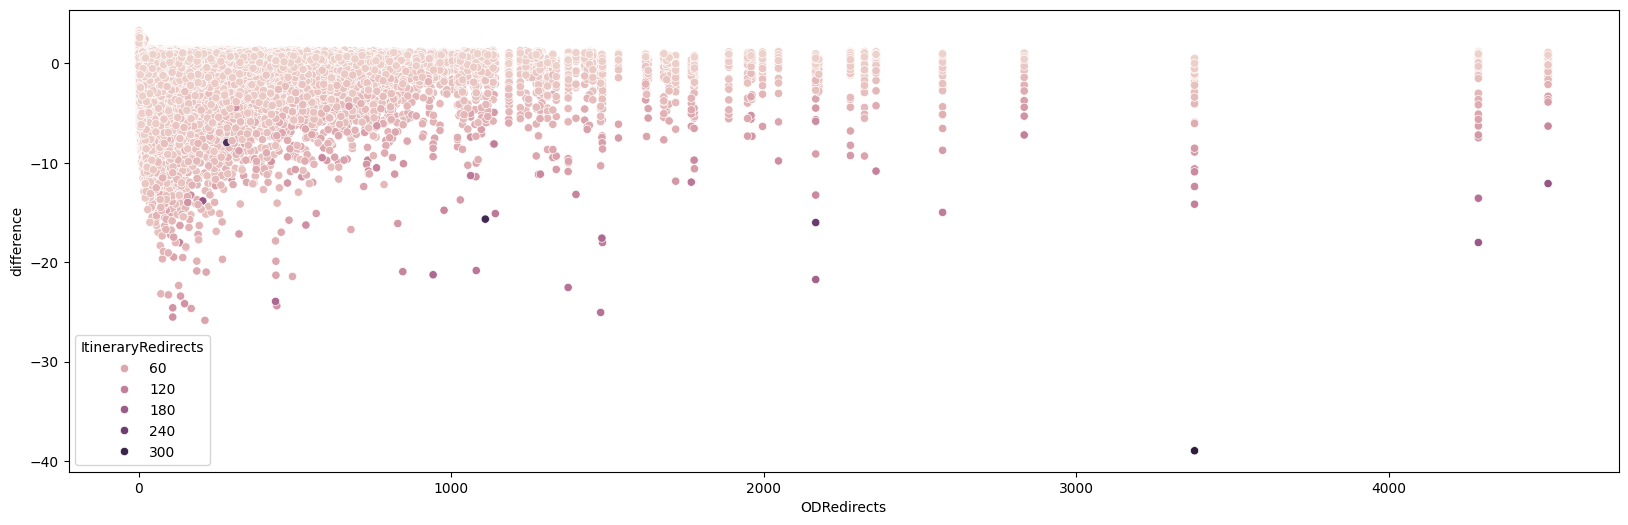

In [180]:
plt.figure(figsize=(20, 6))
sns.scatterplot(knn_50_performance_df, x='ODRedirects', y='difference', alpha=1, hue='ItineraryRedirects')


# Dohop test dataset

In [19]:
dohop_data = pd.read_csv('../raw_data/test_predictions.csv', index_col='Unnamed: 0')


In [20]:
dohop_data['seg_0'] = 0
dohop_data['seg_1'] = 0

for i in range(len(dohop_data)):
    listtt = dohop_data['flights'][i].split(',')
    dohop_data['seg_0'][i] = listtt[0][:2]
    dohop_data['seg_1'][i] = listtt[1].strip()[:2]


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_3444/3831053749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dohop_data['seg_0'][i] = listtt[0][:2]
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_3444/3831053749.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'U2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dohop_data['seg_0'][i] = listtt[0][:2]
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_3444/3831053749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  do

In [21]:
col_rename_dict = {'origin': 'OriginApt', 'destination':'DestinationApt', 'days_to_travel':'TravelHorizonDays', 'total_distance':'total_distance_traveled',
                   'direct_distance':'TravelDistanceKm', 'total_minutes':'DurationMin', 'connection_time':'total_layover_time',
                   'seg_0':'Seg_0_OperatingCarrierIATA', 'seg_1':'Seg_1_OperatingCarrierIATA', 'seg_2':'Seg_2_OperatingCarrierIATA', 'seg_3':'Seg_3_OperatingCarrierIATA'}


In [22]:
dohop_data.drop(columns=['flights', 'connection_airport', 'pax',
                         'bookings', 'total_price', 'predictions'], inplace=True)


In [49]:
def create_df_of_all_categories(raw_data, data_to_be_processed, column):
    """
    This creates a list of all categories, and appends it to existing data that needs processing
    it appends the data, processes it, and drops the unnecesary columns
    It then appends it back to the dataframe so it can be used in the next step
    """

    # Creating dummy data
    categories  = pd.DataFrame(raw_data[column].unique(), columns=[column])

    #Isolating the important data
    # data_for_processing = data_to_be_processed[[column]].copy()

    # Merged data for encoding
    merged_data = pd.concat([data_to_be_processed,categories])

    return merged_data


In [50]:
create_df_of_all_categories(df_with_target, update_col_names, 'DestinationApt')


,OriginApt,DestinationApt,DurationMin,total_layover_time,TravelHorizonDays,total_distance_traveled,TravelDistanceKm,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Seg_0_OperatingCarrierIATA,Seg_1_OperatingCarrierIATA,Seg_2_OperatingCarrierIATA,Seg_3_OperatingCarrierIATA,Stops
0,MRS,MXP,160.0,105.0,9.0,1300.563,403.439,1.0,0.396226,3.223692,113.633395,U2,U2,NaN,NaN,1.0
1,JFK,TNG,565.0,170.0,13.0,7014.057,5811.312,1.0,0.231293,1.206966,289.801556,IB,3O,NaN,NaN,1.0
2,NBE,BRU,210.0,125.0,36.0,1693.643,1691.602,1.0,0.373134,1.001207,74.018052,U2,U2,NaN,NaN,1.0
3,GIB,AMS,255.0,250.0,10.0,2102.413,1963.491,1.0,0.495050,1.070753,284.314697,U2,U2,NaN,NaN,1.0
4,BCN,MCO,710.0,310.0,107.0,8130.504,7402.081,1.0,0.303922,1.098408,438.694302,U2,Z0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,NaN,PEU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2692,NaN,TEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2693,NaN,PLH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,NaN,RFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
def process_new_data(original_data, new_data, PreprocessScalers, box_cox_columns, yeo_johnson_columns):


    #Binary encoding origin
    df_binary = PreprocessScalers.o_encoder.transform(new_data)

    # Binary encoding Destination
    all_destination_cats = create_df_of_all_categories(df_with_target, df_binary, 'DestinationApt')
    all_binary = PreprocessScalers.d_encoder.transform(all_destination_cats)
    all_binary.dropna(subset='Stops', inplace=True)

    # Scaling other features

    # Box cox
    for col in box_cox_columns:
        all_binary[col]  = stats.boxcox(all_binary[col], lmbda=PreprocessScalers.box_lambda)

    # Yeo-johnson
    for col in yeo_johnson_columns:
        all_binary[col] = stats.yeojohnson(all_binary[col], lmbda=PreprocessScalers.yeo_lambda)

    #Min max scaling
    all_binary[min_max_scaling] = PreprocessScalers.minmax_scaler.transform(all_binary[min_max_scaling])

    # # Cyclical encoding
    # all_binary['sin_day'] = np.sin(2 * np.pi * all_binary['dayofweek'] / 7)
    # all_binary['cos_day'] = np.cos(2 * np.pi * all_binary['dayofweek'] / 7)

    # Binary encoding Operator IATA'
    seg_0_cats = create_df_of_all_categories(df_with_target, all_binary, 'Seg_0_OperatingCarrierIATA')
    seg_0_binary = PreprocessScalers.seg_0_encoder.transform(seg_0_cats)
    seg_0_binary.dropna(subset='Stops', inplace=True)

    seg_1_cats = create_df_of_all_categories(df_with_target, seg_0_binary, 'Seg_1_OperatingCarrierIATA')
    seg_1_binary = PreprocessScalers.seg_1_encoder.transform(seg_1_cats)
    seg_1_binary.dropna(subset='Stops', inplace=True)

    seg_2_cats = create_df_of_all_categories(df_with_target, seg_1_binary, 'Seg_2_OperatingCarrierIATA')
    seg_2_binary = PreprocessScalers.seg_2_encoder.transform(seg_2_cats)
    seg_2_binary.dropna(subset='Stops', inplace=True)

    seg_3_cats = create_df_of_all_categories(df_with_target, seg_2_binary, 'Seg_3_OperatingCarrierIATA')
    seg_3_binary = PreprocessScalers.seg_3_encoder.transform(seg_3_cats)
    seg_3_binary.dropna(subset='Stops', inplace=True)

    return seg_3_binary


In [24]:
update_col_names = dohop_data.rename(columns=col_rename_dict)


In [25]:
update_col_names["Seg_2_OperatingCarrierIATA"] = np.nan
update_col_names["Seg_3_OperatingCarrierIATA"] = np.nan
update_col_names["Stops"] = 1


In [65]:
scaled_dohop_data = process_new_data(df_with_target, update_col_names, PreprocessScalers,
                                     box_cox_columns, yeo_johnson_columns).drop(columns='total_layover_time')


In [66]:
X_train.shape


(2698311, 71)

In [67]:
scaled_dohop_data.shape


(3733, 71)

In [68]:
model = load_model('../models/ant_model_071223.h5')


In [69]:
model.predict(scaled_dohop_data)


ValueError: in user code:

    File "/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/antonis/.pyenv/versions/3.11.2/envs/OptiEnv/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 72), found shape=(None, 71)


# When youre back!

Try predict with a model, but you may have to retrain as you kept changing columns that were being trained on. 
1. retriain a model with the X_train you have now
2. Try predict using your new pre-processing functions
3. Clean this notebook up!